# An Analysis of Salaries and Cost of Living in Different US Cities
By James Brunner and Vyoma Jani

# Notes

For purposes of the tutorial, I think it would be better to import each necessary dependency in the notebook cells that require it. This can help the user understand what libraries are needed where.



# Introduction
As college students who are nearing graduation, we are avidly looking at full-time job opportunities across the country. However, different companies and roles offer different salaries, not to mention the stock options and bonuses they may add. This means that the location we work at would be important as well, since the cost of living depends on the location. Our objective is to determine whether salaries are sufficient for living in certain cities.  

add a hypothesis

# Data Collection
The first step in our process is to scour the web in search of relevant data. First, we will be looking at salary data from Levels.fyi. This dataset contains information about employees from various companies, levels, roles, locations, and paygrades, all collected from users who voluntarily provided their information. 

To read in the dataset, we will first generate an HTTP get request using the requests library, and then we will use pandas, a Python library popular for data manipulation and analysis, to convert the json file from the get request into a dataframe. 

In [2]:
import pandas as pd
import requests

salary_url = "https://www.levels.fyi/js/salaryData.json"
salary_data = requests.get(salary_url).json()
salaries = pd.DataFrame(salary_data)
salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127,"Redwood City, CA",1.5,1.5,,107,20,10,,,7392,807,1
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100,"San Francisco, CA",5,3,,,,,,,7419,807,2
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310,"Seattle, WA",8,0,,155,,,,,11527,819,3
3,6/14/2017 21:22:25,Microsoft,64,Software Engineering Manager,200,"Redmond, WA",9,9,,169000,100000,30000,,,11521,819,5
4,6/16/2017 10:44:01,Amazon,L5,Software Engineer,173,"Vancouver, BC, Canada",11,1,,120000,0,53000,,,1320,0,6


IMPORTANT:

we will include the requests code to obtain this data. This will include salary data as recent as the request was made.

In addition, we will write the data we use as a csv and code to read in the csv for purposes of reproducible research.

We will also be looking at the following dataset from Numbeo.com, which provides information regarding the cost of living for various US cities, breaking down the total index into subdivisions like rent index or groceries index. This information is similarly collected voluntarily from users. 

Like before, we will be using pandas and the requests library, but we will also be needing the BeautifulSoup library to parse the html data from the request into the dataframe. 

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

# need to note these are 2020 numbers, and we have salary data from 2017-2020
numbeo_url = 'https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020-mid&region=021'
numbeo_request = requests.get(numbeo_url)
root = BeautifulSoup(numbeo_request.content, 'html.parser')

table = root.find("table", id = "t2")

numbeo = pd.read_html(table.prettify())[0]

numbeo.drop("Rank", axis = 1, inplace = True)

# match format of salaries -- should this been in Data Processing or no? Because it's literally the only change
numbeo["City"] = numbeo["City"].map(lambda x: x.replace(", United States", ""))

numbeo.head()

,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,"New York, NY",100.00,100.00,100.00,100.00,100.00,100.00
1,"San Francisco, CA",92.13,109.76,100.72,89.79,88.26,139.00
2,"Anchorage, AK",90.83,36.51,64.38,89.86,75.91,119.91
3,"Oakland, CA",88.68,79.83,84.37,94.92,72.03,97.98
4,"Boston, MA",88.61,75.13,82.05,89.28,84.34,107.59


# Data Processing
Now that we have gathered our two datasets, we will tidy up the data to make it easier to analyze. For the Levels.fyi data, we will again be needing pandas, and we're also importing the datetime library to help us convert the timestamp information into datetime objects, which will standardize the time. 

For the Levels.fyi dataset, we observe that many of the numeric columns, like totalyearlycompensation, are being stored as strings in the datasets. Because we will be interpreting the values as numbers instead of strings, we will convert the values in those numeric columns to numbers. 

Also, because we are computer science majors, we're only focusing on computer science jobs!

In [4]:
# TODO:
# Fix stock values

import pandas as pd
from datetime import datetime

# Remove unwanted columns
salaries.drop(["tag", "gender", "otherdetails", "cityid", "dmaid", "rowNumber"], axis = 1, inplace = True)

# Filter out non-tech positions 
to_remove = ["Marketing", "Sales", "Recruiter", "Hardware Engineer", "Management Consultant", "Business Analyst"] # can add the others
salaries = salaries[~salaries["title"].isin(to_remove)]

# parsing datetimes
for index, row in salaries.iterrows():
  salaries.at[index, "timestamp"] = datetime.strptime(salaries.at[index, "timestamp"], "%m/%d/%Y %H:%M:%S")

# parsing salary and compensation as numbers
salaries["totalyearlycompensation"] = pd.to_numeric(salaries["totalyearlycompensation"])
salaries["yearsofexperience"] = pd.to_numeric(salaries["yearsofexperience"])
salaries["yearsatcompany"] = pd.to_numeric(salaries["yearsatcompany"])
salaries["basesalary"] = pd.to_numeric(salaries["basesalary"])
salaries["stockgrantvalue"] = pd.to_numeric(salaries["stockgrantvalue"])
salaries["bonus"] = pd.to_numeric(salaries["bonus"])

salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,169000.0,100000.0,30000.0
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,173.0,"Vancouver, BC, Canada",11.0,1.0,120000.0,0.0,53000.0


Before moving into exploratory data analysis, it is important to check our data for outliers and for any values that may have errors or may have been computed incorrectly.

In [5]:
salaries[["totalyearlycompensation", "basesalary", "stockgrantvalue", "bonus"]].describe()

,totalyearlycompensation,basesalary,stockgrantvalue,bonus
count,34328.000000,3.211400e+04,3.175100e+04,30458.000000
mean,230.171828,3.494717e+03,2.747963e+03,493.141231
std,143.270053,2.841416e+04,7.601260e+04,5105.054758
min,10.000000,1.000000e+00,0.000000e+00,0.000000
25%,150.000000,1.200000e+02,9.000000e+00,7.000000
50%,200.000000,1.460000e+02,3.400000e+01,17.000000
75%,277.000000,1.750000e+02,8.000000e+01,30.000000
max,5000.000000,2.000000e+06,1.200000e+07,280000.000000


From these summary statistics, we can observe there are some serious outliers. The mean base salary is $3,287,000, which indicates that we may have some faulty values causing the data to be left-skewed. The same appears to be true for stock grant value and bonus. We can also see how significant the outliers get by observing how large the max for each column is in comparison to the 75th percentile.

In [6]:
# further investigate the counts/number of outliers causing this

# is there a way we can tie MNAR to this? It seems they input their data wrong not knowing it was already counting in thousands

We want to avoid these outliers to prevent our analysis from being skewed, so we will trim the ____ highest and lowest salaries from our dataset. Note that there is a risk of introducing bias here, since it is possible that those trimmed salaries are far from data for a reason relevant to our analysis. 

In [7]:
# ends of the data we will trim. 2.5% off of each end
lower = salaries["basesalary"].quantile(0.025)
upper = salaries["basesalary"].quantile(0.975)

salaries = salaries[(salaries["basesalary"] >= lower) & (salaries["basesalary"] <= upper)]

# TODO impute stockgrantvalue and bonus where possible, else remove the column
# can impute any one if we know the other 3
# can set stock and bonus to 0 if totalyearlycompensation == basesalary


salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0


Our next step in data preparation involves filtering out all jobs that are not located in the United States. We can observe that in the location column of the salaries dataset, locations in the United States are formatted as "City, State" while other countries (such as Canada) are formatted as "City, State/Province, Country". Using Regular Expressions, we can easily filter out these rows.

In [8]:
import re

# to drop non-US:
# regex -> ^[a-z A-Z]+, [A-Z]{2}$
# drop if they dont match this...  Because the country will follow it, unless in U.S.

# Will this keep Washington D.C. ? ---- Yes!! its formatted Washington, DC
regex = r'^[a-z A-Z]+, [A-Z]{2}$'

# check our regex is good -- we lose slightly over 3,000 rows which is fine
print(salaries[~salaries.location.str.contains(regex, regex = True, na = False)]["location"])

# filter
salaries = salaries[salaries.location.str.contains(regex, regex = True, na = False)]

salaries.head()

48                 Dublin, DN, Ireland
135      Cambridge, EN, United Kingdom
179               Bangalore, KA, India
226                             Remote
356                Dublin, DN, Ireland
                     ...              
37302              Berlin, BE, Germany
37305                Kiev, KC, Ukraine
37308              Berlin, BE, Germany
37312             Tel Aviv, TA, Israel
37324             Tel Aviv, TA, Israel
Name: location, Length: 3146, dtype: object


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0


Now that both datasets have been properly cleaned, the last step is to merge them together. One easily noticeable problem is that the Numbeo dataset does not contain all the same cities as the Levels.fyi dataset and therefore we cannot make a simple join between the two.

Since major cities have an influence on the economics of surrounding nearby cities, we will use an algorithm to join each Levels.fyi entry to its closest neighboring city that is in the Numbeo dataset, as long as they are within a reasonable distance from each other.

We will discard of any rows that cannot match a city in our algorithm, as we consider those jobs too far from major U.S. cities and we are not interested in those for the purpose of this analysis.

In [9]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "Final Project")

# step one: get longitude and latitude coordinates in each dataset

def get_coordinates(df, col_name):
  # faster look up instead of querying coordinates for cities we have seen before
  found_cities = {}
  unfound_cities = set()

  longitude_list = []
  latitude_list = []

  for index, row in df.iterrows():
    # we have found this city before and have the coordinates
    if row[col_name] in found_cities:
      longitude_list.append(found_cities[row[col_name]][0])
      latitude_list.append(found_cities[row[col_name]][1])
    else:
      # we already have recorded we can't find this city
      if row[col_name] in unfound_cities:
        longitude_list.append(0)
        latitude_list.append(0)
      else:
        # TODO this can be inconsistent at time -- for some cities, sometimes we find them sometimes we don't
        # It may time out if it can't find the city, so we add a try/except
        try:
          result = geolocator.geocode(row[col_name])
        except:
          result = None
        # new city we couldn't find
        if result is None:
          print("Unfound City:", row[col_name])
          unfound_cities.add(row[col_name])
          longitude_list.append(0)
          latitude_list.append(0)
        # new city we found
        else:
          longitude_list.append(result.longitude)
          latitude_list.append(result.latitude)
          found_cities[row[col_name]] = (result.longitude, result.latitude)

  # return longitude list, latitude list, and those we couldn't find so we can remove those rows
  return longitude_list, latitude_list, unfound_cities


# before we do this, we need to remove NA's from location in the salaries dataset
salaries.dropna(subset = ['location'], inplace = True)

salaries["longitude"], salaries["latitude"], cities_to_drop_salaries = get_coordinates(salaries, "location")
numbeo["longitude"], numbeo["latitude"], cities_to_drop_numbeo = get_coordinates(numbeo, "City")

salaries = salaries[~salaries["location"].isin(cities_to_drop_salaries)]
numbeo = numbeo[~numbeo["City"].isin(cities_to_drop_numbeo)]

salaries = salaries[salaries["longitude"] != 0]
numbeo = numbeo[numbeo["longitude"] != 0]

Unfound City: New York Mills, NY
Unfound City: O Fallon, MO
Unfound City: Brazil, IN


In [10]:
salaries_copy = salaries.copy()
numbeo_copy = numbeo.copy()

bad_rows = salaries_copy[(salaries_copy["latitude"] > 90) | (salaries_copy["latitude"] < -90)]

bad_rows_numb = numbeo_copy[(numbeo_copy["latitude"] > 90) | (numbeo_copy["latitude"] < -90)]

#print(bad_rows_numb.head())

salaries_copy.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,longitude,latitude
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0,-122.232523,37.486324
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN,-122.330062,47.603832
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0,-122.036350,37.368830
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0,-122.123877,47.669414
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0,-122.330062,47.603832


In [11]:
from geopy.distance import geodesic

# step 2: location matching algorithm

# dictionary: salary city name to closest match
# if we dont have it already -- compute it
# must iterate each row in numbeo and keep a min, with the city name
# remember to check distance too -- I will make the max distance 50 miles for now

# this doesn't really need to be a method but whatever
# if we want we could also add a distance column very easily
def location_match(df):
  seen_cities = {} # values are tuple: (city name, distance)
  distance_list = []
  joining_city_list = []

  for index, row in df.iterrows():

    if row["location"] in seen_cities:
      joining_city_list.append(seen_cities[row["location"]][0])
      distance_list.append(seen_cities[row["location"]][1])
    else:
      # start with the first one -- New York, NY
      curr_location = (row["latitude"], row["longitude"])
      comparing_location = (numbeo.at[0, "latitude"], numbeo.at[0, "longitude"])
      min_distance = geodesic(curr_location, comparing_location).miles
      min_city = "New York, NY"
      for index2, row2 in numbeo.iterrows():
        comparing_location = (row2["latitude"], row2["longitude"])
        distance = geodesic(curr_location, comparing_location).miles
        if distance < min_distance:
          min_distance = distance
          min_city = row2["City"]
      joining_city_list.append(min_city)
      distance_list.append(min_distance)
      seen_cities[row["location"]] = (min_city, min_distance)

  return joining_city_list, distance_list

salaries["joining_city"], salaries["distance"] = location_match(salaries)

salaries = salaries[salaries["distance"] <= 50]

# after merging, maybe write to a CSV to make it easy to load and do EDA without having to re-run all the steps above
df = salaries.merge(numbeo, how = 'left', left_on = "joining_city", right_on = "City")

df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,longitude_x,latitude_x,joining_city,distance,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,longitude_y,latitude_y
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0,-122.232523,37.486324,"San Jose, CA",21.471326,"San Jose, CA",77.55,81.32,79.39,69.57,82.46,143.11,-121.890583,37.336191
1,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN,-122.330062,47.603832,"Seattle, WA",0.000000,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832
2,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0,-122.036350,37.368830,"San Jose, CA",8.334578,"San Jose, CA",77.55,81.32,79.39,69.57,82.46,143.11,-121.890583,37.336191
3,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0,-122.123877,47.669414,"Seattle, WA",10.640599,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832
4,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0,-122.330062,47.603832,"Seattle, WA",0.000000,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832


In [12]:
# so we won't have to re-run all the long algorithms
df.to_csv("saved.csv")

# Data Exploration and Analysis
Now that are datasets are clean and organized, it is time to analyze them! 

In [13]:
# IDEA: East Coast vs. West Coast -- could make a really cool map visualization

# matrix of histograms for top 10 companies

# salary vs. years experience vs. cost of living 

# Group by role


# just run this if there were any unwanted changes to the merged df
import pandas as pd
df = pd.read_csv("saved.csv")

Below, we plot the years of experience against the base salary of the 7 roles we are looking to study. We will create separate scatterplots for the roles, and will plot a line of best fit to see if there is some type of linear relationship between the two. 

In [14]:
try:
    import plotly.express as px
except:
    !{sys.executable} -m pip install plotly_express
    import plotly.express as px

# does adding the years at company dimension help us notice anything?
# instead of trimming the outliers, we could rescale the y axis, but this is often considered bad practice
# currently using basesalary instead of totalyearlycompensation

# swap these 2 first lines

# fig = px.scatter(df[df["totalyearlycompensation"] <= 2000], x = "yearsofexperience", y = "totalyearlycompensation", 
fig = px.scatter(df, x = "yearsofexperience", y = "basesalary", 
                color = "yearsatcompany", color_continuous_scale = "rainbow", facet_col = "title", facet_col_wrap = 4, trendline = "ols", 
                labels = {
                    "basesalary": "Base Salary",
                    "yearsofexperience": "Years of Experience", 
                    "facet_col": "title"
                }, title = "Predicting Base Salary based on Years of Experience")
fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Based on the above plots, we can see a positive correlation between years of experience and base salary for each role. 

Now, we will compare base salary to the cost of living index of each location using another scatterplot. 

In [15]:
fig = px.scatter(df, x = "basesalary", y = "Cost of Living Index", trendline = "ols", 
                 labels = {
                     "basesalary": "Base Salary",
                 }, title = "Predicting Cost of Living Index based on Base Salary")

fig.show() 

It's a little hard to tell if the above line of best fit actually represents the data well, since the points are all over the place. Thus, we'll create a matrix of correlations between base salary and the different types of cost of livin indices to see if there's any more specific linear relationships. 

Text(0.5, 1.0, 'Correlation Matrix of Base Salary and Numbeo Cost of Living Indices')

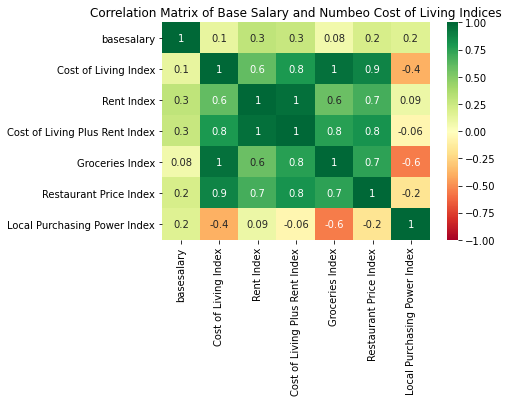

In [16]:
import seaborn as sns

cols = ["basesalary", "Cost of Living Index", "Rent Index", "Cost of Living Plus Rent Index", "Groceries Index", "Restaurant Price Index", "Local Purchasing Power Index"]
sns.heatmap(df[cols].corr(), annot = True, fmt = '.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn').set_title("Correlation Matrix of Base Salary and Numbeo Cost of Living Indices")

The above correlation matrix indicates that we have a slight positive relationship between base salary and every Numbeo index. The strongest relationships base salary has appear to be with Rent Index and Cost of Living Plus Rent Index, with correlations of 0.3.

Now we want to narrow our focus to specific cities and companies. We'll be looking at the average salary per US city and per company in our dataset.

In [17]:
# plot average salary in each city

####### WE STILL HAVE COLUMNS FROM NON-US CITIES SOMEHOW :( :(

mean_df = df[["basesalary", "City"]].groupby("City").mean().reset_index()
count_df = df[["City"]].value_counts().reset_index()

mean_df.rename(columns = {"basesalary": "basesalary_mean"}, inplace = True)
count_df.rename(columns = {0: "count"}, inplace = True)

summary_df = pd.merge(mean_df, count_df, how = "inner", left_on = "City", right_on = "City")

summary_df = pd.merge(summary_df, df, how = "left", left_on = "City", right_on = "City")

wanted_columns = ["City", "longitude_y", "latitude_y", "basesalary_mean", "count", "Rent Index"]

summary_df = summary_df[wanted_columns]
summary_df = summary_df.drop_duplicates()
summary_df


company_df = df[["basesalary", "company"]].groupby("company").mean().reset_index()
company_count_df = df[["company"]].value_counts().reset_index()
company_df = pd.merge(company_df, company_count_df, how = "inner", left_on = "company", right_on = "company")
company_df.rename(columns = {"basesalary": "basesalary_mean"}, inplace = True)
company_df.rename(columns = {0: "count"}, inplace = True)
company_df

,company,basesalary_mean,count
0,Bloomberg,198.0,1
1,Credit Karma,238.0,1
2,Northrop Grumman,79.0,1
3,VMware,97.0,1
4,23andMe,120.0,3
...,...,...,...
897,yelp,135.0,1
898,zillow,175.0,1
899,zillow group,270.0,1
900,zoox,202.5,2


In [23]:
# Top 20 cities

# added count must be at least 100 because of small sample outliers (e.g. Honolulu)
# We should maybe drop these cities from our analysis as a whole
fig = px.bar(summary_df[summary_df["count"] >= 100].nlargest(20, "basesalary_mean"), x = 'City', y = 'Rent Index',
            color = 'basesalary_mean', labels = {
                 'basesalary_mean':'Average Base Salary'
                 }, height = 400)
fig.show()

In [19]:
# Why is San Francisco so much more expensive compared to Oakland and San Jose ?

# Maybe it could be the number of companies there and population?
# We could easily run some aggregate operations to get a count of companies, but population may be annoying


In [20]:
# Top 20 comapanies

# What the heck Netflix!!!! (count >= 100 makes it go away)
fig = px.bar(company_df[company_df["count"] >= 50].nlargest(20, "basesalary_mean"), x = 'company', y = 'basesalary_mean', 
             labels = {
                 'basesalary_mean': 'Average Base Salary',
                 'company': 'Company'
                 }, height = 400)
fig.show()

In [21]:
import folium

def color(salary):
    if salary < 75:
        return "blue"
    elif salary >= 75 and salary < 95:
        return "green"
    elif salary >= 95 and salary < 115:
        return "red"
    elif salary >= 115 and salary < 135:
        return "orange"
    else:
      return "black"

map = folium.Map(location=[48, -102], zoom_start = 4)

for i in range(0, len(summary_df)):
    folium.Circle(
        location = [summary_df.iloc[i]["latitude_y"], summary_df.iloc[i]["longitude_y"]],
        radius = 100000,
        color = color(summary_df.iloc[i]["basesalary_mean"])
    ).add_to(map)
    
map

# Regression and Machine Learning

# Conclusion